## SMT Token Encoder Strategy Analysis

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-10-03 10:06:56.422747: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-03 10:06:57.373673: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-03 10:06:57.659127: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-03 10:06:57.660177: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instruc

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run
from sim.wandb_scrape import *

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 5.8%
RAM Usage: 2.5%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


## Wandb Query <a id="sims"></a>

In [8]:
def fetch_and_summarize_wandb_runs_smt(model, cv_type, null_model, sort_genes='refgenome', token_encoder_dim=60, alibi_slopes=True, feature_type='transcriptome', target='FC', within_last=60, before_last=0, use_weighted=False, exclude='HCP', return_history=False):
    """
    Fetches wandb runs matching specific tags and summarizes their final train/test metrics.
    Handles different CV types with their expected number of runs:
    - random/spatial: 40 runs
    - schaefer: 9 runs  
    - lobe: 6 runs
    
    Args:
        model (str): Model name, e.g., 'bilinear_CM'
        cv_type (str): CV type, one of: 'random', 'spatial', 'schaefer', 'lobe'
        null_model (str): Null model label, e.g., 'none'
        feature_type (str): Feature type, e.g., 'transcriptome_PCA'
        target (str): Target connectome type, e.g., 'FC'
        within_last (int): Search for runs within this many days ago (default: 60)
        before_last (int): Exclude runs from this many days ago (default: 0)
        use_weighted (bool): Whether to compute weighted statistics for schaefer/lobe CV
        exclude (str): Dataset to exclude from search (default: 'HCP')
        return_history (bool): If True, return (summary_df, history_df) tuple
    
    Returns:
        summary_df (pd.DataFrame): DataFrame with mean, std, stderr of all train/test metrics
                                  If use_weighted=True and cv_type in ['schaefer', 'lobe'], 
                                  includes weighted_mean and weighted_stderr rows
        history_df (pd.DataFrame): Individual run data (only returned if return_history=True)
    """
    # Set time filters
    end_time = datetime.now() - timedelta(days=before_last)
    start_time = datetime.now() - timedelta(days=within_last)
    
    # Set expected number of runs based on cv_type
    if cv_type == "schaefer":
        expected_runs = 9
    elif cv_type == "lobe":
        expected_runs = 6
    else:  # random or spatial
        expected_runs = 40
    filters = {
        "tags": {
            "$all": [
                "final_eval",
                f"model_{model}",
                f"target_{target}",
                f"cv_type_{cv_type}",
                f"null_model_{null_model}",
                f"feature_type_{feature_type}", 
                f"sort_genes_{sort_genes}"
            ],
        },
        "config.token_encoder_dim": token_encoder_dim,
        "config.use_alibi": alibi_slopes,
        "created_at": {
            "$gte": start_time.isoformat(), 
            "$lte": end_time.isoformat()
        },
        "state": "finished"
    }
    
    # Add exclusion filter if specified
    if exclude != "":
        filters["tags"]["$nin"] = [f"dataset_{exclude}"]
    
    print(f"🔍 Fetching runs for: model={model}, cv_type={cv_type}, null_model={null_model}, feature_type={feature_type}")
    runs = api.runs(project_path, filters=filters, order="-created_at")
    
    run_data = []
    for run in runs:
        metrics = {}
        summary = run.summary

        # Attempt to extract the pearson_r value (or set to NaN if missing)
        pearson = summary.get("final_test_metrics", {}).get("pearson_r", np.nan)

        # Only consider runs with meaningful final_test_metrics
        if "final_test_metrics" not in summary:
            continue
        
        for k, v in summary.get('final_train_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'train_{k}'] = v

        for k, v in summary.get('final_test_metrics', {}).items():
            if isinstance(v, (int, float)):
                metrics[f'test_{k}'] = v

        metrics['run_name'] = run.name
        metrics['run_id'] = run.id
        metrics['final_test_pearson_r'] = pearson
        
        # Extract fold number for weighted calculations
        if use_weighted and cv_type in ['schaefer', 'lobe']:
            fold_match = re.search(r'fold(\d+)', run.name)
            if fold_match:
                metrics['fold'] = int(fold_match.group(1))
        
        run_data.append(metrics)
    
    df = pd.DataFrame(run_data)

    print(f"📊 Found {len(df)} total runs")

    if len(df) < expected_runs:
        raise ValueError(f"❌ Expected {expected_runs} runs, but found {len(df)}.")

    # Handle deduplication based on CV type
    if use_weighted and cv_type in ['schaefer', 'lobe']:
        # Sort by fold number for proper weight assignment
        df = df.sort_values('fold')
        # Deduplicate by fold keeping highest test pearson_r within each fold
        df_unique = (
            df.sort_values(["fold", "final_test_pearson_r"], ascending=[True, False])
              .drop_duplicates("fold", keep="first")
        )
        print(f"📊 After deduplication: {len(df_unique)} unique runs")
        if len(df_unique) != expected_runs:
            raise ValueError(f"❌ Expected {expected_runs} unique folds, found {len(df_unique)} after deduplication.")
    else:
        # Deduplicate by run_name using highest test pearson_r
        df_unique = (
            df.sort_values("final_test_pearson_r", ascending=False)
              .drop_duplicates("run_name", keep="first")
        )
        print(f"📊 After deduplication: {len(df_unique)} unique runs")
        if len(df_unique) != expected_runs:
            raise ValueError(f"❌ Expected {expected_runs} unique run names, found {len(df_unique)} after deduplication.")

    # Store history before cleaning for aggregation
    history_df = df_unique.copy()
    
    # Clean and summarize
    columns_to_drop = ["run_name", "run_id", "final_test_pearson_r"]
    if 'fold' in df_unique.columns:
        columns_to_drop.append("fold")
    df_clean = df_unique.drop(columns=columns_to_drop, errors="ignore")

    summary_df = pd.DataFrame({
        "mean": df_clean.mean(),
        "std": df_clean.std(),
        "stderr": df_clean.sem()
    }).T
    
    # Add weighted statistics if requested and applicable
    if use_weighted and cv_type in ['schaefer', 'lobe']:
        weights = list(CV_WEIGHTS[cv_type].values())
        
        # Calculate weighted statistics for final_test_pearson_r
        weighted_mean, weighted_se = weighted_mean_and_se(df_unique['final_test_pearson_r'].values, weights)
        summary_df.loc['weighted_mean', 'final_test_pearson_r'] = weighted_mean
        summary_df.loc['weighted_stderr', 'final_test_pearson_r'] = weighted_se
        
        # Calculate weighted statistics for test_pearson_r if it exists
        if 'test_pearson_r' in df_clean.columns:
            test_pearson_values = df_unique['test_pearson_r'].values if 'test_pearson_r' in df_unique.columns else df_clean['test_pearson_r'].values
            weighted_mean_test, weighted_se_test = weighted_mean_and_se(test_pearson_values, weights)
            summary_df.loc['weighted_mean', 'test_pearson_r'] = weighted_mean_test
            summary_df.loc['weighted_stderr', 'test_pearson_r'] = weighted_se_test

    if return_history:
        return summary_df, history_df
    else:
        return summary_df


Random

In [86]:
# Setup common parameters
cv_type = 'random'
null_model = 'none'
before_last = -1
within_last = 3
model_type = 'shared_transformer'

# Dictionary to store results for each dimension
random_results = {}

# Fetch results for each token encoder dimension
for token_encoder_dim in [20, 60, 180]:
    random_results[token_encoder_dim] = {}
    
    # Fetch results with slopes
    alibi_slopes = True
    
    sort_genes = 'refgenome'
    random_results[token_encoder_dim]['ref'] = fetch_and_summarize_wandb_runs_smt(
        model_type, cv_type, null_model, sort_genes=sort_genes, 
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC', 
        within_last=within_last, before_last=before_last
    )

    sort_genes = 'expression'
    random_results[token_encoder_dim]['exp'] = fetch_and_summarize_wandb_runs_smt(
        model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC',
        within_last=within_last, before_last=before_last
    )

    sort_genes = f'{token_encoder_dim}bin_constrained_kmeans'
    random_results[token_encoder_dim]['grn'] = fetch_and_summarize_wandb_runs_smt(
        model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC',
        within_last=within_last, before_last=before_last
    )

    sort_genes = 'random'
    random_results[token_encoder_dim]['rand'] = fetch_and_summarize_wandb_runs_smt(
        model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC',
        within_last=within_last, before_last=before_last
    )

    # Fetch results without slopes
    alibi_slopes = False
    sort_genes = 'random'
    random_results[token_encoder_dim]['rand_noslopes'] = fetch_and_summarize_wandb_runs_smt(
        model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC',
        within_last=within_last, before_last=before_last
    )



🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=random, null_model=none, feature_type=transcriptome
📊 Found 43 total runs
📊 After deduplication: 40 unique run

In [87]:
# Setup common parameters
cv_type = 'spatial'
null_model = 'none'
before_last = -1
within_last = 3
model_type = 'shared_transformer'

# Dictionary to store results for each dimension
spatial_results = {}

# Fetch results for each token encoder dimension
for token_encoder_dim in [20, 60, 180]:
    spatial_results[token_encoder_dim] = {}
    
    # Fetch results with slopes
    alibi_slopes = True
    
    sort_genes = 'refgenome'
    spatial_results[token_encoder_dim]['ref'] = fetch_and_summarize_wandb_runs_smt(
        model_type, cv_type, null_model, sort_genes=sort_genes, 
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC', 
        within_last=within_last, before_last=before_last
    )

    sort_genes = 'expression'
    spatial_results[token_encoder_dim]['exp'] = fetch_and_summarize_wandb_runs_smt(
        model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC',
        within_last=within_last, before_last=before_last
    )

    sort_genes = f'{token_encoder_dim}bin_constrained_kmeans'
    spatial_results[token_encoder_dim]['grn'] = fetch_and_summarize_wandb_runs_smt(
        model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC',
        within_last=within_last, before_last=before_last
    )

    sort_genes = 'random'
    spatial_results[token_encoder_dim]['rand'] = fetch_and_summarize_wandb_runs_smt(
        model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC',
        within_last=within_last, before_last=before_last
    )

    # Fetch results without slopes
    alibi_slopes = False
    sort_genes = 'random'
    spatial_results[token_encoder_dim]['rand_noslopes'] = fetch_and_summarize_wandb_runs_smt(
        model_type, cv_type, null_model, sort_genes=sort_genes,
        token_encoder_dim=token_encoder_dim, alibi_slopes=alibi_slopes,
        feature_type='transcriptome', target='FC',
        within_last=within_last, before_last=before_last
    )


🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 40 total runs
📊 After deduplication: 40 unique runs
🔍 Fetching runs for: model=shared_transformer, cv_type=spatial, null_model=none, feature_type=transcriptome
📊 Found 41 total runs
📊 After deduplication: 40 uniq

In [88]:
def plot_smt_tokenization_performance(results, cv_type, metric='test_long_r'):
    # Create grouped bar plot
    plt.figure(figsize=(15, 6))

    # Set width of bars and positions of the bars
    bar_width = 0.15
    r1 = np.arange(3)  # For the 3 dimensions
    r2 = [x + 3 + bar_width for x in r1]
    r3 = [x + 3 + bar_width for x in r2]
    r4 = [x + 3 + bar_width for x in r3]
    r5 = [x + 3 + bar_width for x in r4]

    # Colors for each sorting method
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']

    # Plot bars for each sorting method
    sorting_methods = ['ref', 'exp', 'grn', 'rand', 'rand_noslopes']
    labels = ['Reference Genome', 'Expression', 'GRN Clusters', 'Random w/slopes', 'Random no slopes']

    # Get all means and errors to determine y-axis limits
    all_means = []
    all_errs = []
    for method in sorting_methods:
        means = [results[dim][method].loc['mean', metric] for dim in [20, 60, 180]]
        errs = [results[dim][method].loc['stderr', metric] for dim in [20, 60, 180]]
        all_means.extend(means)
        all_errs.extend(errs)

    # Calculate y-axis limits with padding based on max standard error
    min_val = min(all_means)
    max_val = max(all_means)
    max_err = max(all_errs)
    y_min = min_val - 3*max_err
    y_max = max_val + 3*max_err

    for i, (method, label) in enumerate(zip(sorting_methods, labels)):
        means = [results[dim][method].loc['mean', metric] for dim in [20, 60, 180]]
        errs = [results[dim][method].loc['stderr', metric] for dim in [20, 60, 180]]
        
        positions = [x + i*bar_width for x in r1]
        bars = plt.bar(positions, means, bar_width, yerr=errs, capsize=3, 
                       label=label, color=colors[i], alpha=0.8)
        
        # Add value labels
        for idx, rect in enumerate(bars):
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., height + errs[idx],
                    f'{means[idx]:.3f}'[1:],
                    ha='center', va='bottom', rotation=0, fontsize=10)

    # Customize plot
    plt.ylabel(f'{metric}')
    plt.title(f'Mean {cv_type} Split Performance by Tokenization Strategy ({metric})')
    plt.xticks([r + 2*bar_width for r in r1], ['20 dim', '60 dim', '180 dim'])
    plt.legend(loc='upper left', prop={'size': 12})
    plt.ylim(y_min, y_max)

    # Show plot
    plt.tight_layout()
    plt.show()

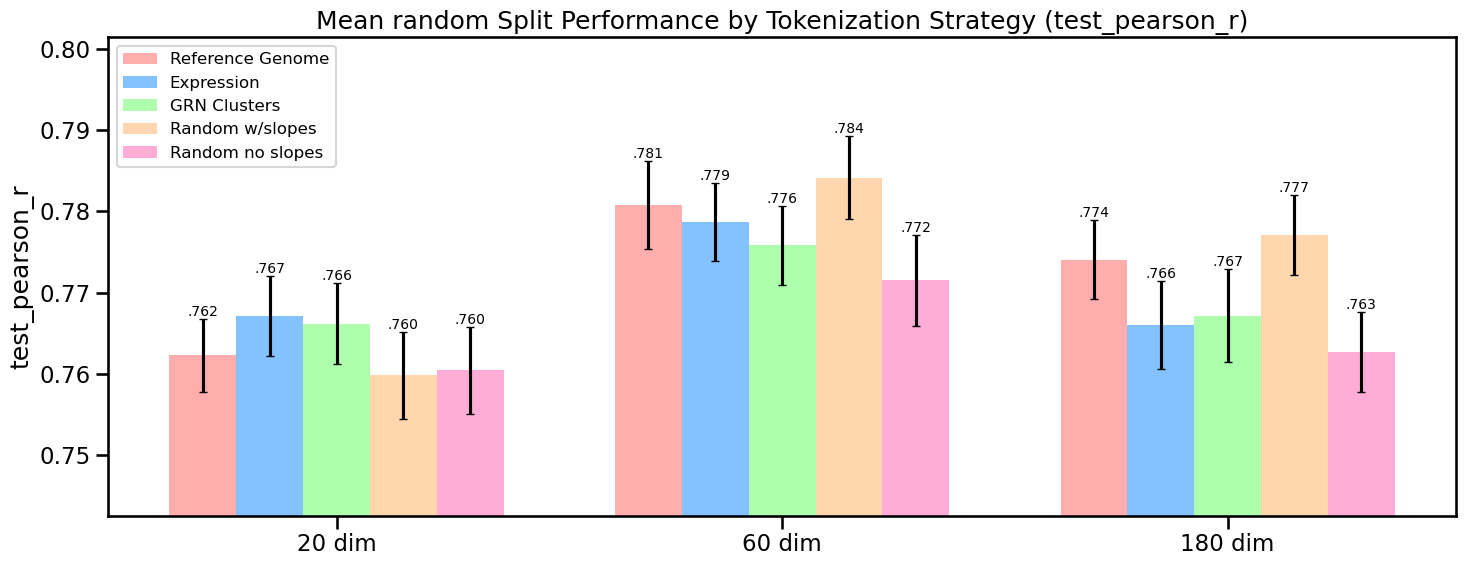

In [89]:
plot_smt_tokenization_performance(random_results, cv_type='random', metric='test_pearson_r')


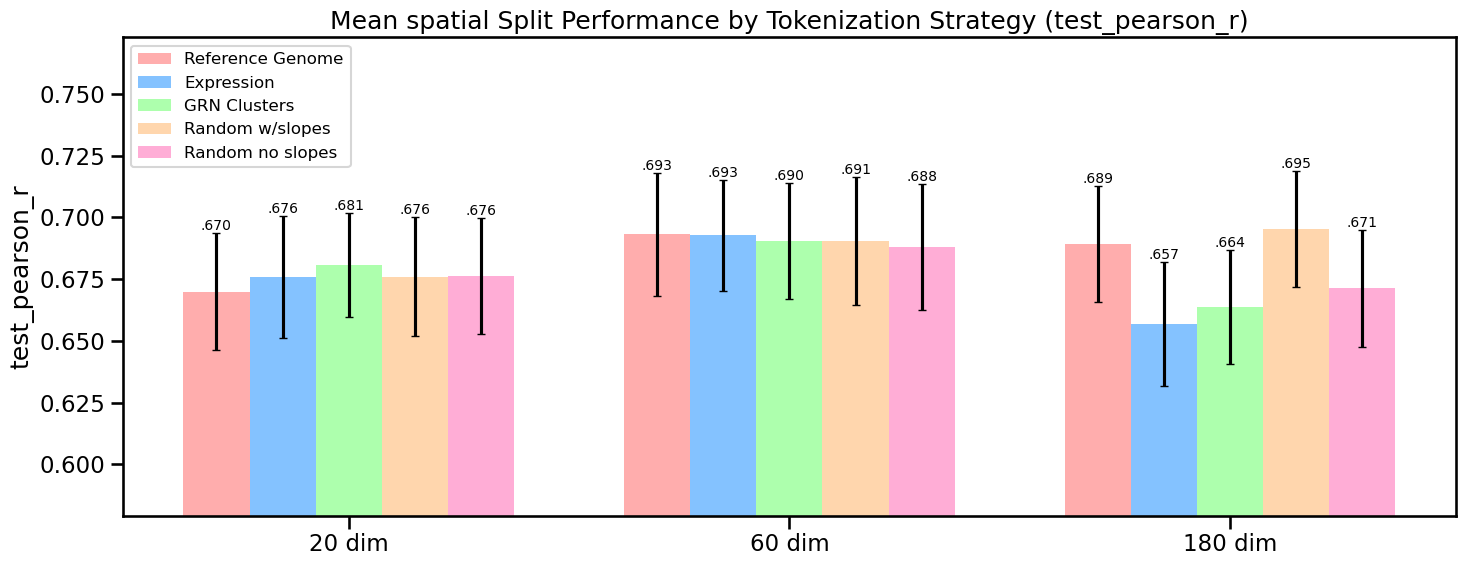

In [90]:
plot_smt_tokenization_performance(spatial_results, cv_type='spatial', metric='test_pearson_r')